<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
data_dir = '../data/amplicon_comparison'
inf_z = az.from_netcdf(f'{data_dir}/differentials_z.nc')
inf_d = az.from_netcdf(f'{data_dir}/differentials_d.nc')
inf_b = az.from_netcdf(f'{data_dir}/differentials_b.nc')

z_diff = inf_z['posterior']['diff'].to_dataframe()
d_diff = inf_d['posterior']['diff'].to_dataframe()
b_diff = inf_b['posterior']['diff'].to_dataframe()

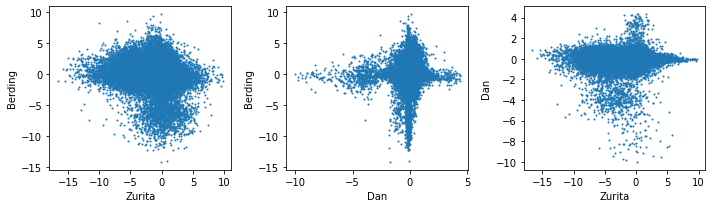

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(z_diff.values, b_diff.values, s=1)
ax[1].scatter(d_diff.values, b_diff.values, s=1)
ax[2].scatter(z_diff.values, d_diff.values, s=1)
ax[0].set_xlabel('Zurita')
ax[0].set_ylabel('Berding')
ax[1].set_xlabel('Dan')
ax[1].set_ylabel('Berding')
ax[2].set_xlabel('Zurita')
ax[2].set_ylabel('Dan')
plt.tight_layout()

In [21]:
z_diff

diff
features chain draw          
1033731  0     0    -0.989090
               1     0.078484
               2    -0.347360
               3    -0.379561
               4     0.337366
...                       ...
999419   3     95   -1.465460
               96   -1.527040
               97   -0.632259
               98   -0.249851
               99   -0.925463

[64400 rows x 1 columns]

In [22]:
d_diff

diff
features chain draw          
1033731  0     0     0.085244
               1     0.075808
               2     0.118783
               3     0.266181
               4     0.185725
...                       ...
999419   3     95   -0.226080
               96   -0.447636
               97   -0.390804
               98   -0.328098
               99   -0.349763

[64400 rows x 1 columns]